## AIMI High School Internship 2024
### Notebook 0: Data preprocessing

**The Problem**: The task is to develop a model that can classify chest X-ray images into one of four categories: pneumonia, pneumothorax, pleural effusion, and normal. This classification task is essential in the medical field as it helps in the early diagnosis and treatment of various lung conditions. The dataset we'll be using for this project is the CheXpert dataset, which contains a large number of chest radiographs along with their corresponding radiologist reports.

**Your First Task**: Given a set of chest X-rays and radiology reports, your first goal is to map each image to its report.

**Looking Ahead**: When you complete this task, you should better understand the training dataset and know how to build mappings from images to the corresponding reports. You will later use these reports to generate labels for their corresponding image.

### Load Data

Upload `student_data_split.zip`. It should take some time for these files to be uploaded. Then, run the following cells to unzip the dataset (which should take < 10 seconds)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
# Switch directory to the
os.chdir(r'/content/drive/MyDrive/Cody - AIMI 2024/2024 AIMI Summer Internship - Intern Materials/Datasets/')

In [ ]:
!unzip -qq student_data_split_small.zip -d /content/

unzip:  cannot find or open student_data_split_small.zip, student_data_split_small.zip.zip or student_data_split_small.zip.ZIP.


### Understanding the Data

Let's first go through some terminology. Medical data is often stored in a hierarchy consisting of three levels: patient, study, and images.
- Patient: A patient is a single unique individual.
- Study: Each patient may have multiple sets of images taken, perhaps on different days. Each set of images is referred to as a *study*.
- Images: Each study may consist of one or more *images*.

Chest X-ray images and radiology reports are stored in `student_data_split/` and are organized as follows:
- `student_data_split/student_train`:
  - Images: The CheXpert **training set** consists of 10884 subfolders, each representing a patient. Every patient has one or more studies, which are stored as subfolders. Images are stored in study folders as `.jpg` files.
- `student_data_split/student_test`: The CheXpert **test set** is organized in a similar fashion as the CheXpert training set. Note that this is a held-out test set with 2766 folders that we will use for scoring models, so reports are not provided!
- `student_data_split/Reports.json`: This Json file stores all reports for each of the images in the **training set**. Each item includes a 'study_id' and 'report'

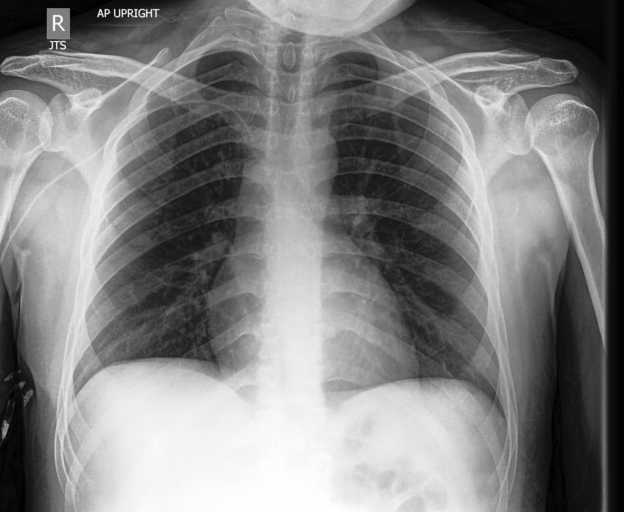

In [ ]:
# Example Image
from PIL import Image
img = Image.open(r"/content/student_data_split (small)/student_train/patient00612/study2/view1_frontal.jpg")
#img.show()

img

In [ ]:
# Example Reports
import json

# Load the Reports.json file
with open('/content/student_data_split (small)/Reports.json', 'r') as file:
    reports = json.load(file)

# show the first five reports
reports[:5]

[{'study_id': 'student_train/patient39668/study2',
  'report': 'NARRATIVE:\nExam: Chest 1 View, 6-19-2003\n \nClinical History: 64 years Female with Critical  care follow-up(ICU)\n \nComparison: 6/19/2003\n \nIMPRESSION:\n \n1.AP SUPINE CHEST RADIOGRAPH DEMONSTRATES INTERVAL PLACEMENT OF A \nRIGHT IJ VENOUS LINE, WITH THE TIP IN THE MID-SVC.\n \n2.STABLE CARDIOMEDIASTINAL SILHOUETTE.\n \n3.INCREASED RETICULAR MARKINGS ARE SEEN IN THE LUNGS BILATERALLY, \nWITH PERIBRONCHIAL CUFFING THAT COULD REPRESENT EARLY PULMONARY EDEMA.\n \n4.INCREASED OPACIFICATION IS SEEN IN THE RETROCARDIAC LUNG, \nCONCERNING FOR DEVELOPING INFECTION.\n \n5.MILD ATELECTASIS IN THE RIGHT MID AND LOWER ZONES.\n \n6.DEGENERATIVE CHANGES IN THE LOWER CERVICAL SPINE.\n \nSUMMARY:4-POSSIBLY SIGNIFICANT FINDING, MAY NEED ACTION\n \n \n \nACCESSION NUMBER:\n4047176\nThis report has been anonymized. All dates are offset from the actual dates by a fixed interval associated with the patient.'},
 {'study_id': 'student_train

In [ ]:
# Define the target study_id
target_study_id = 'student_train/patient26819/study2'

# Find the report with the target study_id
filtered_report = next((item['report'] for item in reports if item['study_id'] == target_study_id), None)

print(filtered_report)

NARRATIVE:
COMPARISON: 1/9/2003.
IMPRESSION:
1. THE ENDOTRACHEAL TUBE HAS BEEN REMOVED. NASOGASTRIC TUBE IS
STABLE IN POSITION. THERE IS A NEW LEFT SUBCLAVIAN CATHETER WITH
THE TIP IN THE BRACHIOCEPHALIC VEIN AT THE SVC JUNCTION.
2. NO DEFINITE EVIDENCE OF PNEUMOTHORAX. THERE ARE PERSISTENT LOW
LUNG VOLUMES WITH BIBASILAR ATELECTASIS. THERE ARE LIKELY SMALL
BILATERAL PLEURAL EFFUSIONS.
END OF IMPRESSION
SUMMARY: 2 ABNORMAL, PREVIOUSLY REPORTED
I have personally reviewed the images for this examination and agree
with the report transcribed above.
By: Ian, Warren  on: 1-9-2003
 
ACCESSION NUMBER:
JBXEFIJH
This report has been anonymized. All dates are offset from the actual dates by a fixed interval associated with the patient.


In [ ]:
import re

def get_patient_report(target_study_id):
  filtered_report = next((item['report'] for item in reports if item['study_id'] == target_study_id), None)
  patient_id = re.search(r"patient\d+", target_study_id).group(0)

  return [patient_id, filtered_report]

print(get_patient_report("student_train/patient26819/study2"))


['patient26819', 'NARRATIVE:\nCOMPARISON: 1/9/2003.\nIMPRESSION:\n1. THE ENDOTRACHEAL TUBE HAS BEEN REMOVED. NASOGASTRIC TUBE IS\nSTABLE IN POSITION. THERE IS A NEW LEFT SUBCLAVIAN CATHETER WITH\nTHE TIP IN THE BRACHIOCEPHALIC VEIN AT THE SVC JUNCTION.\n2. NO DEFINITE EVIDENCE OF PNEUMOTHORAX. THERE ARE PERSISTENT LOW\nLUNG VOLUMES WITH BIBASILAR ATELECTASIS. THERE ARE LIKELY SMALL\nBILATERAL PLEURAL EFFUSIONS.\nEND OF IMPRESSION\nSUMMARY: 2 ABNORMAL, PREVIOUSLY REPORTED\nI have personally reviewed the images for this examination and agree\nwith the report transcribed above.\nBy: Ian, Warren  on: 1-9-2003\n \nACCESSION NUMBER:\nJBXEFIJH\nThis report has been anonymized. All dates are offset from the actual dates by a fixed interval associated with the patient.']


In [ ]:
patient_ids = os.listdir('/content/student_data_split (small)/student_train')
patient_ids.remove(".DS_Store")

patient_reports = []
for patient_id in patient_ids:
  study_number = os.listdir(f'/content/student_data_split (small)/student_train/{patient_id}')[0]
  patient_reports.append(get_patient_report(f"student_train/{patient_id}/{study_number}"))


import pandas as pd
df = pd.DataFrame(patient_reports, columns=['Patient ID', 'Report'])
df


,Patient ID,Report
0,patient09566,NARRATIVE:\nTWO-VIEW CHEST X-RAY: 12/29/2016\n...
1,patient31367,"NARRATIVE:\nExam: Chest 1 View, 3/9/2016\n \nC..."
2,patient61625,NARRATIVE:\nPORTABLE CHEST ONE VIEW: December ...
3,patient59818,"NARRATIVE:\nEXAM: Chest 1 View, 3/22/13.\n \nH..."
4,patient02946,NARRATIVE:\nTWO VIEWS CHEST: 2/7/2015 2318 ...
...,...,...
56,patient60393,"NARRATIVE:\nExam: Chest 2 Views, 3-2-04\n \nCl..."
57,patient37090,NARRATIVE:\nPORTABLE CHEST X-RAY: 8-13-08.\n ...
58,patient20671,NARRATIVE:\nRADIOGRAPHIC EXAMINATION OF THE CH...
59,patient27833,NARRATIVE:\nCHEST ONE VIEW: 4-4-2005\nCLINICAL...
